In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
sns.set_style("darkgrid")

In [12]:
os.path

<module 'ntpath' from 'c:\\Python38\\lib\\ntpath.py'>

In [14]:
# df = pd.read_csv('./jointVel_bodyVel_3D_1leg_DB_.csv')
# df = pd.read_csv('./jointVel_bodyVel_3D_hindleg_DB_.csv')
# df = pd.read_csv('./jointVel_bodyVel_3D_1leg_Quadruped_.csv')
df = pd.read_csv('./jointVel_bodyVel_3D_inverse_leg_Quadruped_.csv')
# df = pd.read_csv("C:\\Program Files\\CoppeliaRobotics\\CoppeliaSimEdu\\scenes\\SOLM\\jointVel_bodyVel_3D.csv")
df.head()

,Time (s),Joint Vel 1,Joint Vel 2,Joint Vel 3,Body Vel X,Body Vel Y,Body Vel Z
0,1.00,0.000,0.0,0.0,0.0,0.000,0.000
1,1.01,0.524,0.0,0.0,0.0,0.122,-0.066
2,1.02,0.916,0.0,0.0,0.0,0.259,-0.098
3,1.03,1.014,0.0,0.0,0.0,0.308,-0.109
4,1.04,1.039,0.0,0.0,0.0,0.312,-0.114


In [25]:
# Filter out rows where Joint Vel 1, Joint Vel 2, and Joint Vel 3 are all zero
df = df[~((abs(df["JointVel 1"]) < 0.1) & (abs(df["JointVel 2"]) < 0.1) & (abs(df["JointVel 3"]) < 0.05))]

KeyError: 'JointVel 1'

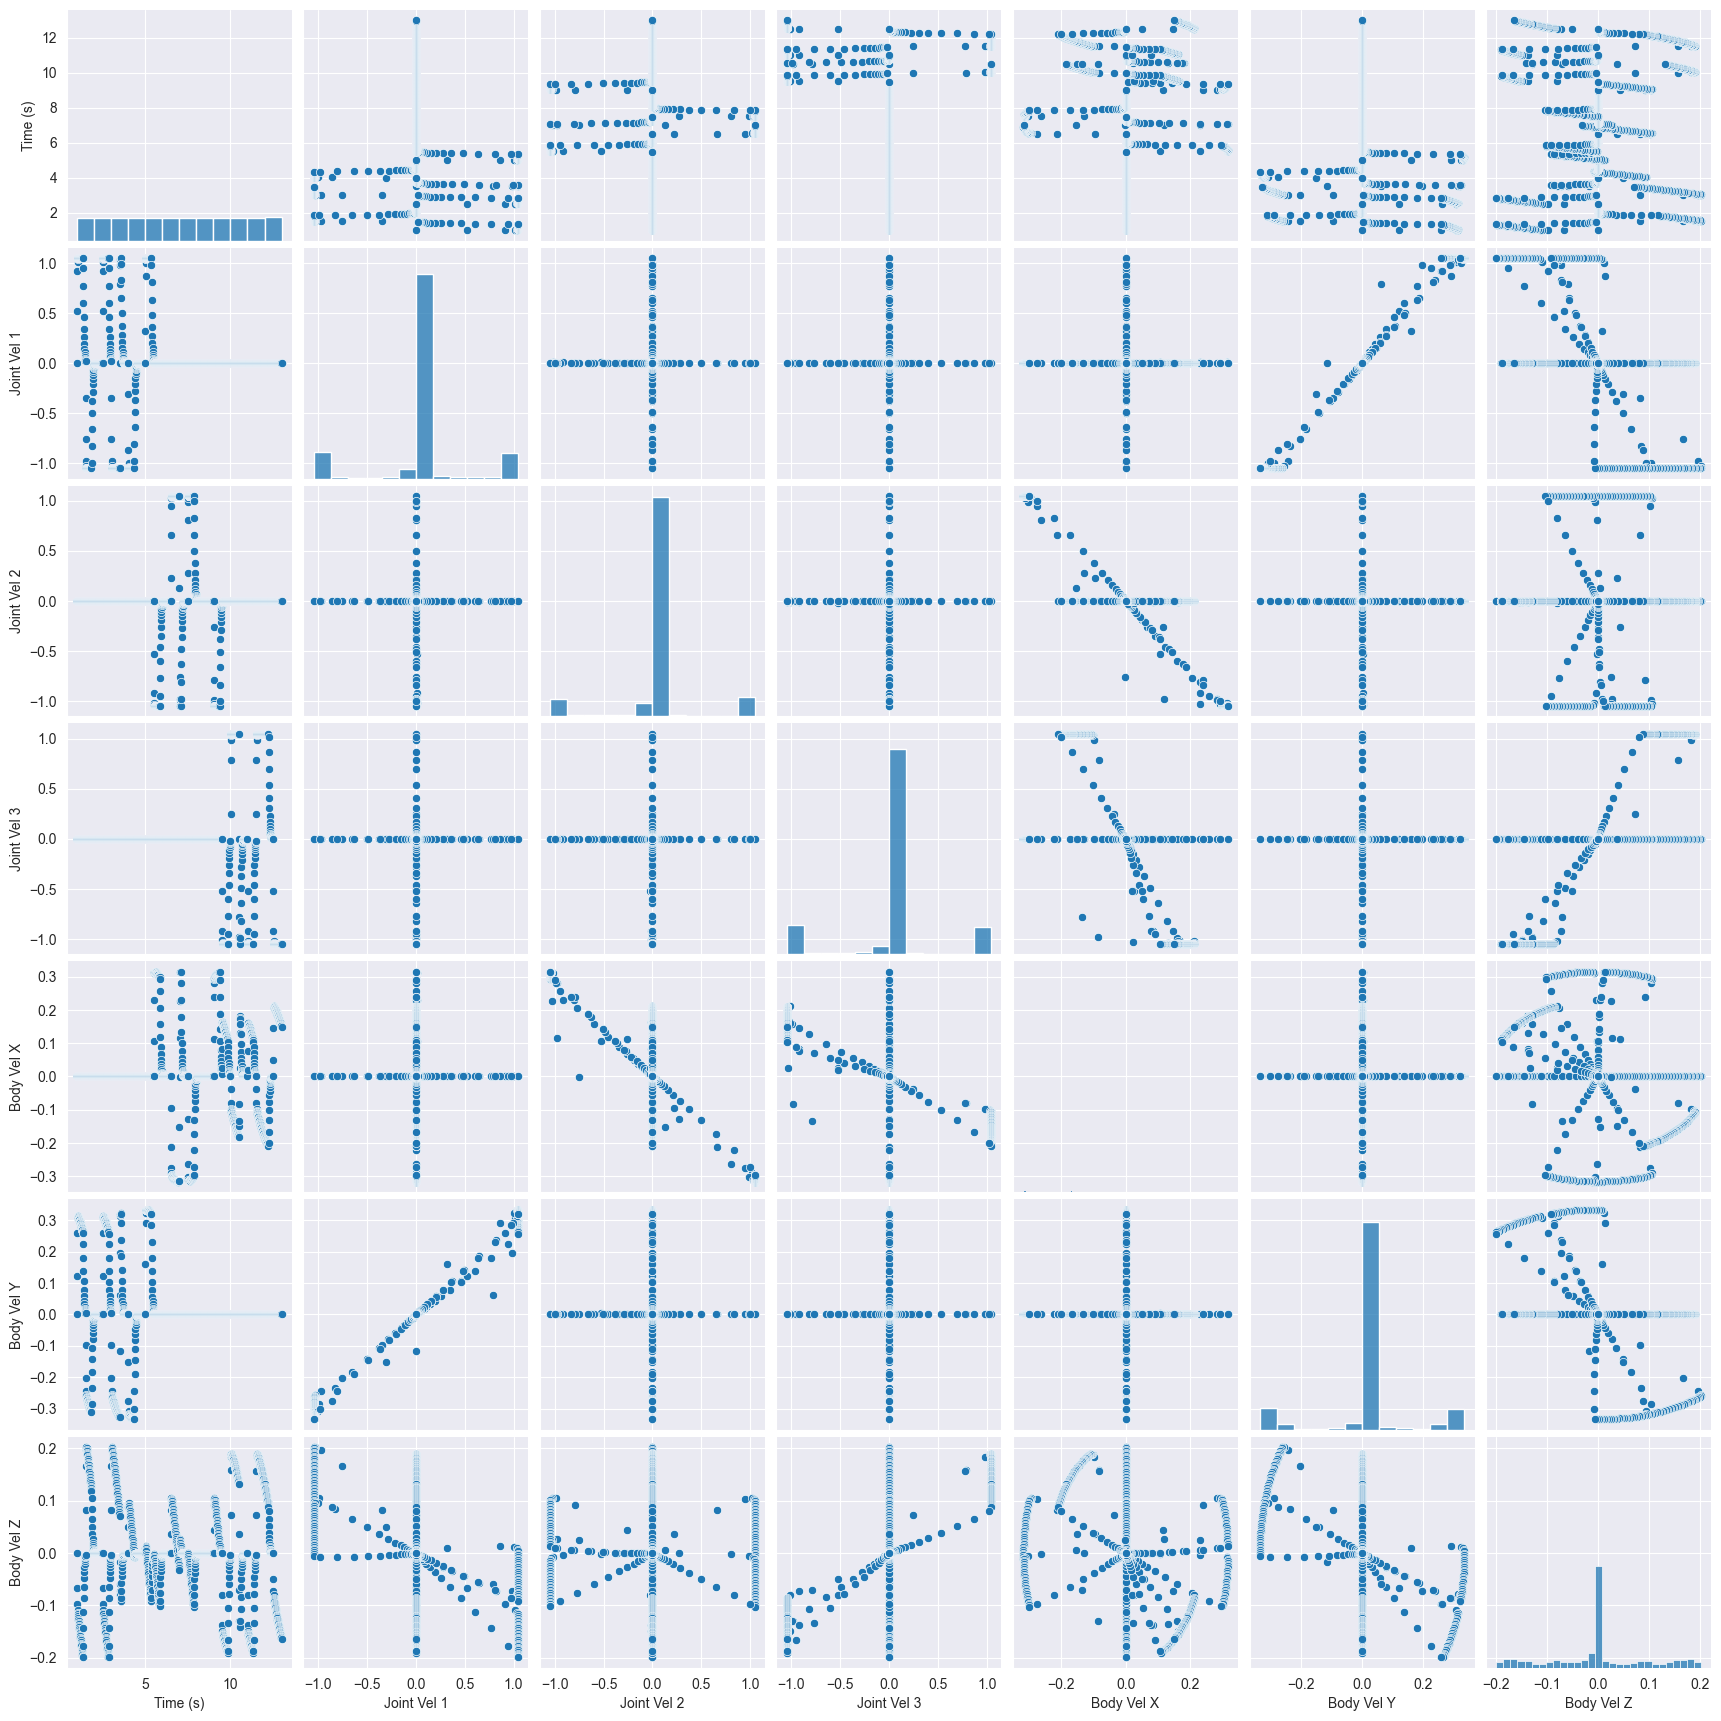

In [15]:
# independent joitn activation (calibrate data)
sns.pairplot(df)

In [16]:
# Step 1: Melt the joint velocities into a single 'Joint Vel' column with a 'Joint Number'
df_joint_melt = df.melt(id_vars=['Time (s)'], 
                        value_vars=['Joint Vel 1', 'Joint Vel 2', 'Joint Vel 3'],
                        var_name='Joint Number', 
                        value_name='Joint Vel')

# Extract the joint number from the column name and clean it up
df_joint_melt['Joint Number'] = df_joint_melt['Joint Number'].str.extract('(\d)').astype(int)

# Step 2: Melt the body velocities into a single 'Body Vel' column with an 'Axis'
df_body_melt = df.melt(id_vars=['Time (s)'], 
                       value_vars=['Body Vel X', 'Body Vel Y', 'Body Vel Z'],
                       var_name='Body Axis', 
                       value_name='Body Vel')

# Extract the axis from the column name and clean it up
df_body_melt['Body Axis'] = df_body_melt['Body Axis'].str.extract('([XYZ])')

# Step 3: Merge the two melted DataFrames back into one (on Time)
df_final = pd.merge(df_joint_melt, df_body_melt, on='Time (s)')

# Show the resulting DataFrame
df_final

,Time (s),Joint Number,Joint Vel,Body Axis,Body Vel
0,1.0,1,0.000,X,0.000
1,1.0,1,0.000,Y,0.000
2,1.0,1,0.000,Z,0.000
3,1.0,2,0.000,X,0.000
4,1.0,2,0.000,Y,0.000
...,...,...,...,...,...
10804,13.0,2,0.000,Y,0.000
10805,13.0,2,0.000,Z,-0.164
10806,13.0,3,-1.047,X,0.150
10807,13.0,3,-1.047,Y,0.000


C:\Users\binggwong\AppData\Local\Temp\ipykernel_90564\4220753205.py:5: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
C:\Users\binggwong\AppData\Local\Temp\ipykernel_90564\4220753205.py:11: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


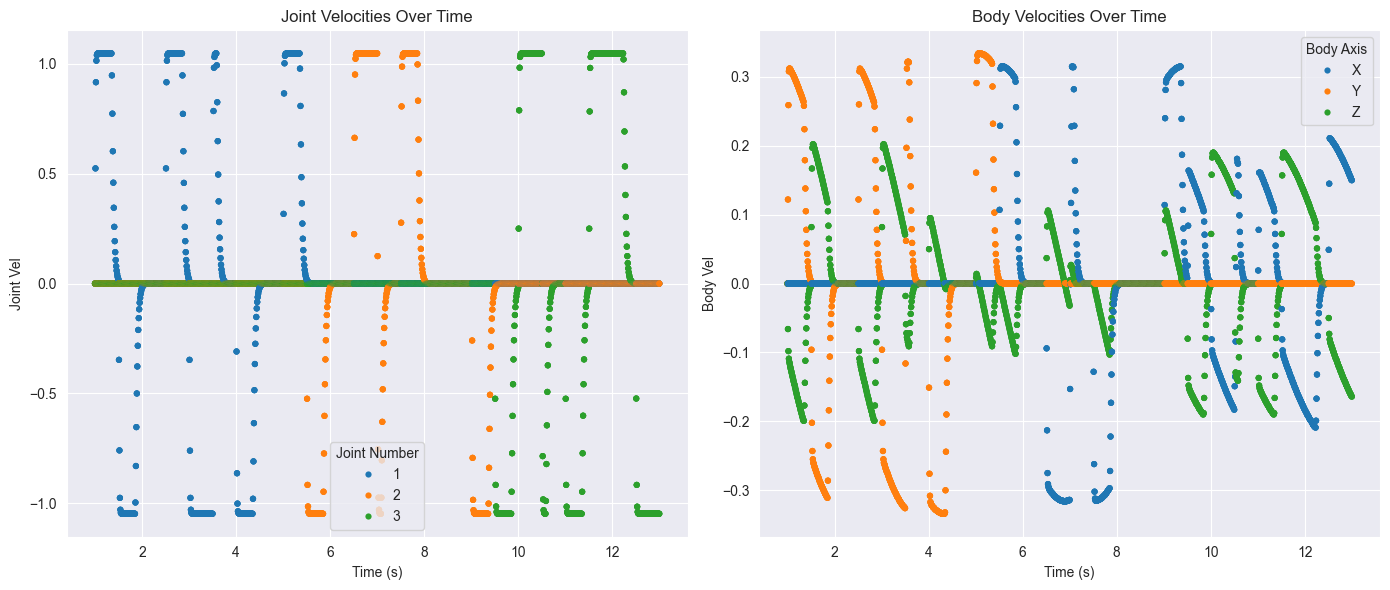

In [17]:
# Create a figure with two subplots (left and right)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First relational plot (left)
sns.scatterplot(
    x='Time (s)', y='Joint Vel', hue='Joint Number', data=df_final, ax=axes[0], palette=sns.color_palette(),edgecolor='none', s=20
)
axes[0].set_title('Joint Velocities Over Time')

# Second relational plot (right)
sns.scatterplot(
    x='Time (s)', y='Body Vel', hue='Body Axis', data=df_final, ax=axes[1], palette=sns.color_palette(), edgecolor='none', s=20 
)
axes[1].set_title('Body Velocities Over Time')

# Adjust layout to avoid overlap
plt.tight_layout()
# Show the combined plots
plt.show()

In [18]:
# Define X (input features) and Y (output labels) in a generalized way
X = df[["Joint Vel 1", "Joint Vel 2", "Joint Vel 3"]].values  # Input: Joint velocities
Y = df[["Body Vel X", "Body Vel Y", "Body Vel Z"]].values      # Output: Body velocities

# Solve the linear regression using the normal equation: W = (X.T X)^(-1) X.T Y
W = np.linalg.inv(X.T @ X) @ X.T @ Y

# Print the estimated weights (Jacobian matrix)
print("Estimated Jacobian Matrix (W):")
print(W)

Estimated Jacobian Matrix (W):
[[-2.72969301e-06  2.88314366e-01 -1.13121768e-01]
 [-2.92120647e-01  1.55960425e-06 -2.00172836e-03]
 [-1.45666386e-01 -3.70047588e-10  1.45861523e-01]]


In [ ]:
# Add a small epsilon to avoid division by zero
epsilon = 1e-8  # Small value to prevent division by zero

# Compute the maximum along the columns, but add epsilon to prevent division by zero
sum_joint_contr = np.sum(abs(W), axis=0, keepdims=True) + epsilon
print(sum_joint_contr)

# Perform the division safely
W_normalized = W / sum_joint_contr

# Print the result
print("Normalize Jacobian Matrix (W):")
print(W_normalized)


[[0.24530001 0.50440001 0.23670001]]
Normalize Jacobian Matrix (W):
[[ 0.02119853  0.20915939 -0.31094211]
 [ 0.68569096  0.44528151  0.26024502]
 [ 0.29311047  0.34555907  0.42881283]]


In [7]:
W_new = np.array([
    [-0.0370, 0.2161, -0.0505],
    [0.2593, 0.0030, 0.0395],
    [0.0638, 0.0317, 0.0994]
])

# Add a small epsilon to avoid division by zero
epsilon = 1e-8  # Small value to prevent division by zero

# Compute the maximum along the columns, but add epsilon to prevent division by zero
sum_joint_contr = np.sum(abs(W_new), axis=0, keepdims=True) + epsilon
print(sum_joint_contr)

# Perform the division safely
W_normalized = W_new / sum_joint_contr

# Print the result
print("Normalize Jacobian Matrix (W):")
print(W_normalized)


[[0.36010001 0.25080001 0.18940001]]
Normalize Jacobian Matrix (W):
[[-0.10274923  0.86164271 -0.26663145]
 [ 0.72007774  0.01196172  0.20855332]
 [ 0.177173    0.12639553  0.52481518]]


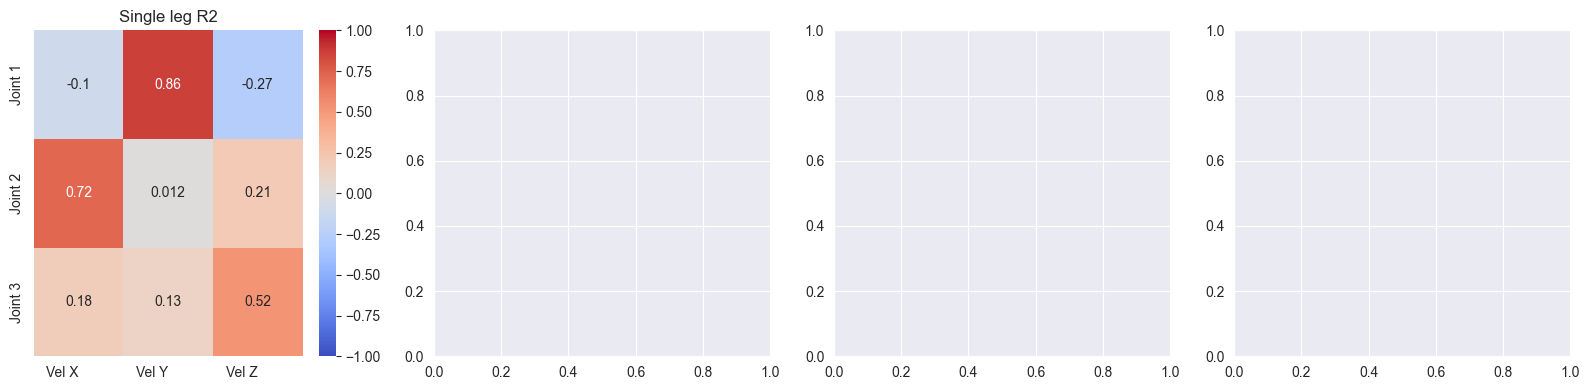

In [8]:
# Set up the figure for subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Loop over each matrix and plot it as a heatmap
sns.heatmap(W_normalized, annot=True, cmap='coolwarm', center=0, ax=axes[0], 
            vmin=-1, vmax=1, cbar=True)
axes[0].set_title("Single leg R2")
axes[0].set_xticklabels(['Vel X', 'Vel Y', 'Vel Z'], ha='right')
axes[0].set_yticklabels(['Joint 1', 'Joint 2', 'Joint 3'], ha='right')

plt.tight_layout()
plt.show()

In [198]:
# Prediction for new joint velocities (optional)
new_joint_velocities = np.array([[1.0, 0.0, 0.0]])  # Example input
predicted_body_velocities = new_joint_velocities @ W
print("\nPredicted Body Velocities for new joint velocities:")
print(predicted_body_velocities)



Predicted Body Velocities for new joint velocities:
[[-0.28836441 -0.00059568  0.        ]]


In [139]:
df['Body Vel X'], df['Body Vel Y'], df['Body Vel Z']

(0     -0.000
 1     -0.260
 2     -0.488
 3     -0.610
 4     -0.621
        ...  
 898    0.000
 899    0.000
 900    0.000
 901    0.000
 902    0.000
 Name: Body Vel X, Length: 903, dtype: float64,
 0     -0.000
 1     -0.001
 2     -0.011
 3     -0.025
 4     -0.039
        ...  
 898    0.000
 899    0.000
 900    0.000
 901    0.000
 902    0.000
 Name: Body Vel Y, Length: 903, dtype: float64,
 0     -0.0
 1     -0.0
 2     -0.0
 3     -0.0
 4     -0.0
       ... 
 898   -0.0
 899   -0.0
 900   -0.0
 901   -0.0
 902   -0.0
 Name: Body Vel Z, Length: 903, dtype: float64)

In [140]:
# Generate synthetic data
# X is the input matrix with shape (n_samples, 3), where n_samples = 100
np.random.seed(42)
n_samples = 100
X = np.random.rand(n_samples, 3)

# Define a true weight matrix W_true and bias b_true for generating outputs
W_true = np.array([[2, -1, 0.5],
                   [1.5, 2, -0.5],
                   [1, 0, 1]])

b_true = np.array([1, 2, 3])

# Generate outputs Y using the linear relationship Y = XW_true + b_true
Y = X @ W_true + b_true

# Linear regression solution using normal equation
# Adding a column of ones to X for the bias term
X_b = np.hstack([X, np.ones((n_samples, 1))])

# Solve for the weights and bias using normal equation: W = (X_b.T X_b)^(-1) X_b.T Y
W_b = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ Y

# Extract the weight matrix W and bias vector b from the result
W_est = W_b[:-1, :]  # First 3 rows are weights
b_est = W_b[-1, :]   # Last row is the bias

# Output the estimated weights and bias
print("Estimated weight matrix W:")
print(W_est)

print("\nEstimated bias vector b:")
print(b_est)

# Compare with the true weights and bias
print("\nTrue weight matrix W_true:")
print(W_true)

print("\nTrue bias vector b_true:")
print(b_true)


Estimated weight matrix W:
[[ 2.00000000e+00 -1.00000000e+00  5.00000000e-01]
 [ 1.50000000e+00  2.00000000e+00 -5.00000000e-01]
 [ 1.00000000e+00 -1.45678929e-15  1.00000000e+00]]

Estimated bias vector b:
[1. 2. 3.]

True weight matrix W_true:
[[ 2.  -1.   0.5]
 [ 1.5  2.  -0.5]
 [ 1.   0.   1. ]]

True bias vector b_true:
[1 2 3]


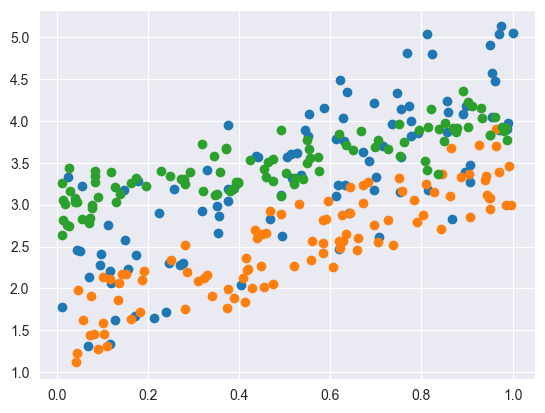

In [141]:
X_new = np.random.rand(100, 3)  # New input sample
Y_pred = X_new @ W_est + b_est

for i in range(3):
    # plt.scatter(X[:,i], Y[:,i])
    plt.scatter(X_new[:,i], Y_pred[:,i])

## Full body Compliance Experiment

In [4]:
df = pd.read_csv("C:\\Program Files\\CoppeliaRobotics\\CoppeliaSimEdu\\scenes\\SOLM\\Compliance_JVel_BVel_fullbody.csv")
df.head()

,Time (s),JointVel_1_R1,JointVel_2_R1,JointVel_3_R1,JointVel_1_R2,JointVel_2_R2,JointVel_3_R2,JointVel_1_L1,JointVel_2_L1,JointVel_3_L1,JointVel_1_L2,JointVel_2_L2,JointVel_3_L2,Body Vel X,Body Vel Y,Body Vel Z
0,1.00,-0.001,0.001,-0.001,-0.001,0.002,-0.002,0.000,0.002,-0.002,0.000,0.002,-0.001,0.0,0.0,0.0
1,1.01,0.000,0.001,0.000,0.000,0.000,-0.001,0.001,0.001,-0.001,0.001,0.000,0.000,0.0,0.0,0.0
2,1.02,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
3,1.03,-0.001,-0.001,0.001,-0.001,0.000,0.000,-0.001,-0.001,0.001,-0.001,0.000,0.000,0.0,0.0,0.0
4,1.04,0.000,-0.001,0.001,0.000,-0.001,0.001,0.000,-0.001,0.001,0.000,-0.001,0.001,0.0,0.0,0.0
